In [44]:
import math
import numpy as np
import scipy.optimize as opt
import scipy.stats as sts
import pandas as pd 
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve
from rouwen import rouwen
from numba import jit
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sy
from sympy import diff as diff
from sympy.utilities import lambdify as lambdify
from matplotlib import cm

## Exercise 1

We are tasked with deriving $x_{uuu}(u_0)$. This is done as follows (where $u = u_0$) using Pascal's Triangle:

\begin{equation}
\begin{split}
x_{uuu}(u_0) =& \ \frac{F_{xxx}\{x(u),u\}x_u{u}^3 + 3F_{uxx}\{x(u),u\}x_u{u}^2 + 3F_{uux}\{x(u),u\}x_u{u} + F_{uuu}\{x(u),u\}}{F_x\{x(u_0),u\}}
\end{split}
\end{equation}

## Exercise 2

We seek to model an economy. We use the following characterizing equations:

\begin{equation}
\begin{split}
n^d = & \ \bigg[ \frac{(1-\alpha)}{w} \bigg]^{\frac{1}{\alpha}}k \\
\pi = & \ zk^{\alpha}(n^{d})^{1-\alpha} - wn^d \\
n^s = & \ h - \frac{b}{w(1+b)}(wh+\pi-t)
\end{split}
\end{equation}

Parameterization:

In [45]:
alpha = 0.33
k_0 = 5
z = 1
b = 2
t = 0.1
h = 24

params = (alpha,k_0,z,b,t,h)

We now build the solve function for our Euler equations:

In [46]:
def Prob1_Eulers(w,*parameters):
    alpha,k,z,b,t,h = parameters
    nd = (((1-alpha)*z*(1/w))**(1/alpha))*k
    pi = z*(k**alpha)*((nd)**(1-alpha))-w*(nd)
    ns = h-(b/(w*(1+b)))*(w*h+pi-t)
    return ns-nd

Solving for the market-clearing wage:

In [47]:
r_5 = opt.fsolve(Prob1_Eulers,0.5,args=(params))
print("Equilibrium wage at k = 5:   ",r_5[0])

Equilibrium wage at k = 5:    0.627361779044


Next we solve for the optimal solution at natural numbers $k  < 15$:

In [48]:
kmax = 15
wgrid_0 = np.empty(kmax)
for i in range(kmax):
    params_i = (alpha,i+1,z,b,t,h)
    r_i = opt.fsolve(Prob1_Eulers,0.5,args=(params_i))
    wgrid_0[i] = r_i[0]
    print("Equilibrium wage at k =",i+1," :",wgrid_0[i])

Equilibrium wage at k = 1  : 0.367737272318
Equilibrium wage at k = 2  : 0.462947959249
Equilibrium wage at k = 3  : 0.529616674311
Equilibrium wage at k = 4  : 0.582630997221
Equilibrium wage at k = 5  : 0.627361779044
Equilibrium wage at k = 6  : 0.666435406702
Equilibrium wage at k = 7  : 0.70135622641
Equilibrium wage at k = 8  : 0.733075716849
Equilibrium wage at k = 9  : 0.762238375438
Equilibrium wage at k = 10  : 0.789303333896
Equilibrium wage at k = 11  : 0.814610581895
Equilibrium wage at k = 12  : 0.838419732183
Equilibrium wage at k = 13  : 0.860934032284
Equilibrium wage at k = 14  : 0.882315930235
Equilibrium wage at k = 15  : 0.902697550485


Next we determine the linear, first-order, second-order approximations for our grid:

In [49]:
points = np.array([5,10])
wgrid_1,wgrid_2 = np.empty((len(points),kmax)),np.empty((len(points),kmax))
e = 1e-6
for j,node in enumerate(points):
    for i in range(kmax):
        params_i_1 = (alpha,node-e,z,b,t,h)
        params_i_2 = (alpha,node+e,z,b,t,h)
        r_1 = opt.fsolve(Prob1_Eulers,0.5,args=(params_i_1))[0]
        r_2 = opt.fsolve(Prob1_Eulers,0.5,args=(params_i_2))[0]
        deriv_1 = (r_2 - r_1)/(2*e)
        wgrid_1[j,i] = wgrid_0[node-1] + deriv_1*(i+1-node)
        deriv_2 = (r_2 + r_1 - 2*wgrid_0[node-1])/(e**2)
        wgrid_2[j,i] = wgrid_0[node-1] + deriv_1*(i+1-node) + 0.5*deriv_2*((i+1-node)**2)

We now graph our results:

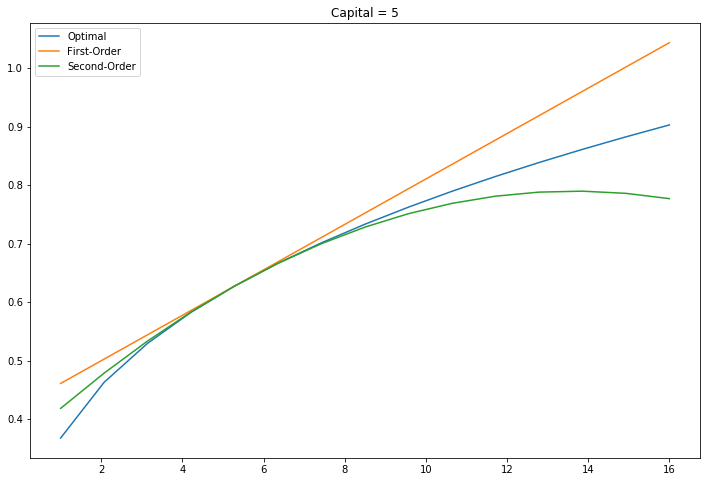

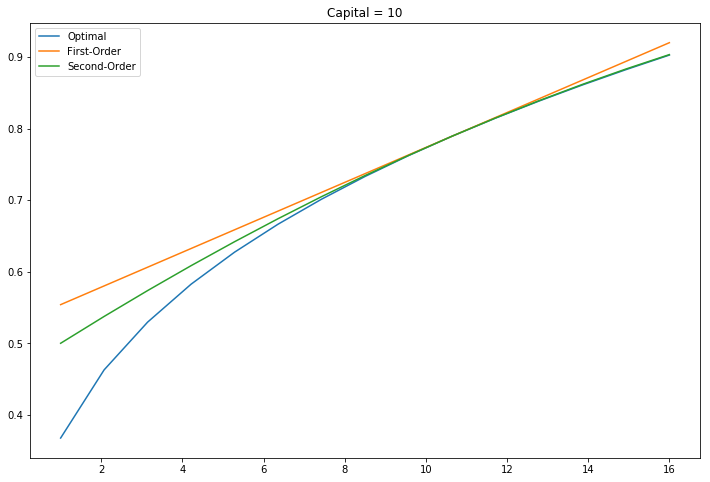

In [50]:
plt.figure(figsize=(12,8))
plt.title("Capital = 5")
plt.plot(np.linspace(1,16,15),wgrid_0, label="Optimal")
plt.plot(np.linspace(1,16,15),wgrid_1[0,:], label="First-Order")
plt.plot(np.linspace(1,16,15),wgrid_2[0,:], label="Second-Order")
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title("Capital = 10")
plt.plot(np.linspace(1,16,15),wgrid_0, label="Optimal")
plt.plot(np.linspace(1,16,15),wgrid_1[1,:], label="First-Order")
plt.plot(np.linspace(1,16,15),wgrid_2[1,:], label="Second-Order")
plt.legend()
plt.show()

## Question 3

We are given the following function to optimize and approximate:

\begin{equation}
\begin{split}
F(x,y) = (x^{0.35} + 0.9x - y)^{-2.5} - 0.95(y^{0.35} + 0.9y)^{-2.5} = 0
\end{split}
\end{equation}

about the point $x_0 = 100$. Note that we are given $y_0 = G(x_0) = 49.2166$. We set out to find the third-order perturbation. First we create a function in python in the given form, and establish given values:

In [51]:
x0 = 100

def F(x,y):
    return (x**(.35) + .9*x - y)**(-2.5) - .95*(y**(.35) + .9*y)**(-2.5)

def Fg(xt):
    y0 = 9
    t_func = lambda yt : np.abs(F(xt,yt))
    return opt.minimize(t_func,y0,tol=1e-15)

y0 = Fg(x0).x[0]
print("Fg(100)  : ",y0)

Fg(100)  :  47.4657875325


Notice that the minimize routine finds a different solution than is given in the problem; we will use this new value ($G(100) = 47.466$). We then find the first, second, and third derivatives using symbolic algebra. We also create lambda functions for easy calculations later on.

In [52]:
x,y = sy.symbols("x y")

F1_x_func = sy.diff(F(x,y),x)
F1_y_func = sy.diff(F(x,y),y)
F2_xx_func = sy.diff(F1_x_func,x)
F2_xy_func = sy.diff(F1_x_func,y)
F2_yy_func = sy.diff(F1_y_func,y)
F3_xxx_func = sy.diff(F2_xx_func,x)
F3_xxy_func = sy.diff(F2_xx_func,y)
F3_xyy_func = sy.diff(F2_xy_func,y)
F3_yyy_func = sy.diff(F2_yy_func,y)

F1_x = lambda u,v: F1_x_func.evalf(subs={x:u,y:v})
F1_y = lambda u,v: F1_y_func.evalf(subs={x:u,y:v})
F2_xx = lambda u,v: F2_xx_func.evalf(subs={x:u,y:v})
F2_xy = lambda u,v: F2_xy_func.evalf(subs={x:u,y:v})
F2_yy = lambda u,v: F2_yy_func.evalf(subs={x:u,y:v})
F3_xxx = lambda u,v: F3_xxx_func.evalf(subs={x:u,y:v})
F3_xxy = lambda u,v: F3_xxy_func.evalf(subs={x:u,y:v})
F3_xyy = lambda u,v: F3_xyy_func.evalf(subs={x:u,y:v})
F3_yyy = lambda u,v: F3_yyy_func.evalf(subs={x:u,y:v})

Calculate the linear, second-order, and third-order approximations:

In [53]:
Xu = -((F1_x(x0,y0))/(F1_y(x0,y0)))
Xuu = -((F2_xx(x0,y0) + 2*F2_xy(x0,y0) + F2_yy(x0,y0))/(F1_y(x0,y0)))
Xuuu = -((F3_xxx(x0,y0) + 3*F3_xxy(x0,y0) + 3*F3_xyy(x0,y0) + F3_yyy(x0,y0))/(F1_y(x0,y0)))

y_approx_linear = lambda xp : y0 + Xu*((xp-x0))
y_approx_quadratic = lambda xp : y0 + Xu*((xp-x0)) + 0.5*Xuu*((xp-x0)**2)
y_approx_cubic = lambda xp : y0 + Xu*((xp-x0)) + 0.5*Xuu*((xp-x0)**2) + (1/6)*Xuuu*((xp-x0)**3)

print("First-Order Approximation of G(100)   : ",y_approx_linear(99))
print("Second-Order Approximation of G(100)  : ",y_approx_quadratic(99))
print("Third-Order Approximation of G(100)   : ",y_approx_cubic(99))

First-Order Approximation of G(100)   :  46.9947022810595
Second-Order Approximation of G(100)  :  47.0116195838907
Third-Order Approximation of G(100)   :  47.0121357179975


To verify the robustness of our solutions, we solve over the grid $x \in [99,101]$:

In [54]:
xgrid = np.linspace(99,101,200)
ygrid_1,ygrid_2,ygrid_3,ygrid_r = np.empty_like(xgrid),np.empty_like(xgrid),np.empty_like(xgrid),np.empty_like(xgrid)
for i in range(len(xgrid)):
    ygrid_1[i] = y_approx_linear(xgrid[i])
    ygrid_2[i] = y_approx_quadratic(xgrid[i])
    ygrid_3[i] = y_approx_cubic(xgrid[i])
    ygrid_r[i] = Fg(xgrid[i]).x[0]

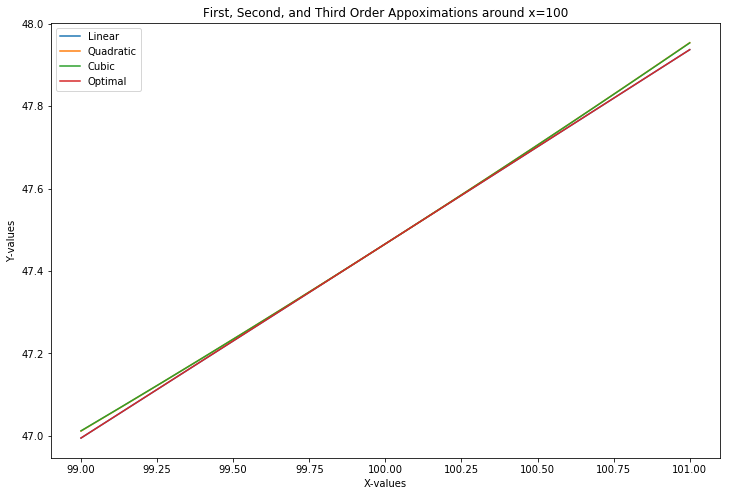

In [55]:
plt.figure(figsize=(12,8))
plt.plot(xgrid,ygrid_1, label = "Linear")
plt.plot(xgrid,ygrid_2, label = "Quadratic")
plt.plot(xgrid,ygrid_3, label = "Cubic")
plt.plot(xgrid,ygrid_r, label = "Optimal")
plt.title("First, Second, and Third Order Appoximations around x=100")
plt.xlabel("X-values")
plt.ylabel("Y-values")
plt.legend()
plt.show()

We also plot the difference between the linear, quadratic, and cubic approximations:

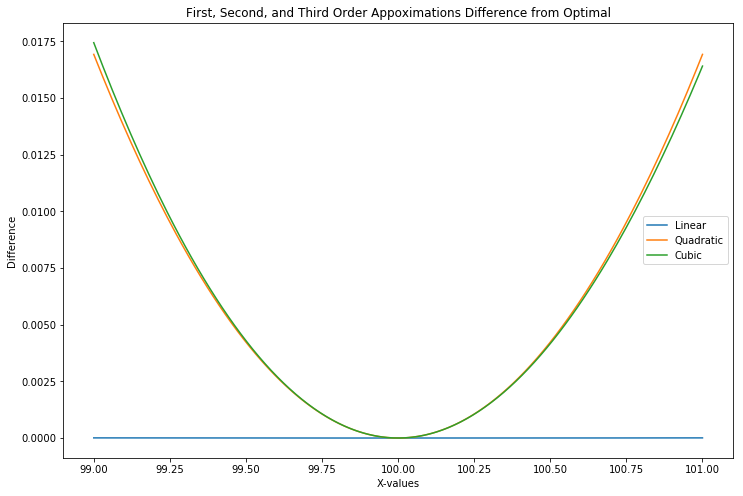

In [56]:
plt.figure(figsize=(12,8))
plt.plot(xgrid,abs(ygrid_1 - ygrid_r), label = "Linear")
plt.plot(xgrid,abs(ygrid_2 - ygrid_r), label = "Quadratic")
plt.plot(xgrid,abs(ygrid_3 - ygrid_r), label = "Cubic")
plt.title("First, Second, and Third Order Appoximations Difference from Optimal")
plt.xlabel("X-values")
plt.ylabel("Difference")
plt.legend()
plt.show()

## Question 4

We seek to build a perturbation model for the Brock & Mirman model; specifically, find the scalar values $H_X$ and $H_{XX}$ in order to build a second-order approximation. We first have parameterization and building the $k,z$ grids:

In [57]:
x,y = None,None
alpha = 0.35
beta = 0.98
rho = 0.95
sigma = 0.02
params = np.array([alpha,beta,rho,sigma])
sizek = 100
zbar = 0

kbar = (alpha*beta)**(1/(1-alpha))
grid = np.linspace(0.5*kbar,1.5*kbar,sizek)

We now build our equations for the linear and quadratic approximations:

In [58]:
def F_BM(u,x,y,params):
    alpha,beta,rho,sigma = params
    return (1/(u**alpha - x) - beta*((alpha*(x**(alpha-1)))/(x**alpha - y)))

In [59]:
u,x,y = sy.symbols("u x y")

F_BM1_u_func = sy.diff(F_BM(u,x,y,params),u)
F_BM1_x_func = sy.diff(F_BM(u,x,y,params),x)
F_BM1_y_func = sy.diff(F_BM(u,x,y,params),y)
F_BM2_uu_func = sy.diff(F_BM1_u_func,u)
F_BM2_xu_func = sy.diff(F_BM1_x_func,u)
F_BM2_yu_func = sy.diff(F_BM1_y_func,u)
F_BM2_yx_func = sy.diff(F_BM1_y_func,x)
F_BM2_xx_func = sy.diff(F_BM1_x_func,x)
F_BM2_yy_func = sy.diff(F_BM1_y_func,y)

F_BM1_u = lambda p,q,s: F_BM1_u_func.evalf(subs={u:p,x:q,y:s})
F_BM1_x = lambda p,q,s: F_BM1_x_func.evalf(subs={u:p,x:q,y:s})
F_BM1_y = lambda p,q,s: F_BM1_y_func.evalf(subs={u:p,x:q,y:s})
F_BM2_uu = lambda p,q,s: F_BM2_uu_func.evalf(subs={u:p,x:q,y:s})
F_BM2_xu = lambda p,q,s: F_BM2_xu_func.evalf(subs={u:p,x:q,y:s})
F_BM2_yu = lambda p,q,s: F_BM2_yu_func.evalf(subs={u:p,x:q,y:s})
F_BM2_yx = lambda p,q,s: F_BM2_yx_func.evalf(subs={u:p,x:q,y:s})
F_BM2_xx = lambda p,q,s: F_BM2_xx_func.evalf(subs={u:p,x:q,y:s})
F_BM2_yy = lambda p,q,s: F_BM2_yy_func.evalf(subs={u:p,x:q,y:s})

And build the model:

In [60]:
u_coef,x_coef,y_coef = F_BM1_u(kbar,kbar,kbar),F_BM1_x(kbar,kbar,kbar),F_BM1_y(kbar,kbar,kbar)
temp_x = lambda c : abs(y_coef*(c**2) + x_coef*c + u_coef)
Xu_bm = opt.minimize(temp_x,0.5).x[0]

Xuu_bm = -((F_BM2_yy(kbar,kbar,kbar)*(Xu_bm**4) + 2*F_BM2_yx(kbar,kbar,kbar)*(Xu_bm**3) + 
         2*F_BM2_yu(kbar,kbar,kbar)*(Xu_bm**2) + F_BM2_xx(kbar,kbar,kbar)*(Xu_bm**2) +
         2*F_BM2_xu(kbar,kbar,kbar)*(Xu_bm)    + F_BM2_uu(kbar,kbar,kbar)) / 
        (F_BM1_y(kbar,kbar,kbar)*(Xu_bm**2) + F_BM1_y(kbar,kbar,kbar)*(Xu_bm) + F_BM1_x(kbar,kbar,kbar)))

k_approx_linear_bm = lambda K : kbar + Xu_bm*(K-kbar)
k_approx_quadratic_bm = lambda K : kbar + Xu_bm*(K-kbar) + 0.5*Xuu_bm*(K-kbar)**2

In [61]:
Kvec_linear = np.empty(sizek)
Kvec_quadratic = np.empty(sizek)
Kvec_real = np.empty(sizek)
for i,k in enumerate(grid):
    Kvec_linear[i] = k_approx_linear_bm(k)
    Kvec_quadratic[i] = k_approx_quadratic_bm(k)
    Kvec_real[i] = (kbar**(1-alpha))*(k**alpha)

We then graph our outcome, comparing the three models for estimating the policy function:

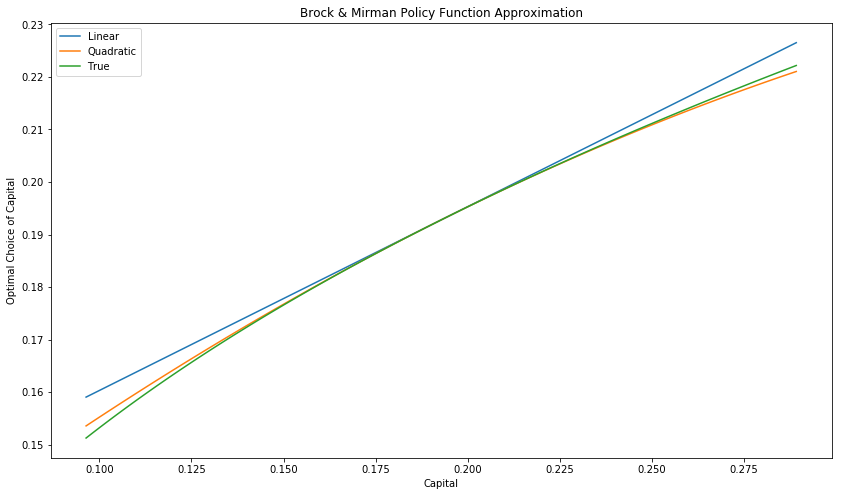

In [62]:
plt.figure(figsize=(14,8))
plt.plot(grid,Kvec_linear,label="Linear")
plt.plot(grid,Kvec_quadratic,label="Quadratic")
plt.plot(grid,Kvec_real,label="True")
plt.legend()
plt.title("Brock & Mirman Policy Function Approximation")
plt.xlabel("Capital")
plt.ylabel("Optimal Choice of Capital")
plt.show()

## Exercise 5

We now add in exogenous shocks and a variance term to our model above. First is parameterization, finding the steady state of the system, and solving for the standard linearization coefficients:

In [63]:
alpha = 0.35
beta = 0.98
rho = 0.95
sigma = 0.02
kbar = (alpha*beta)**(1/(1 - alpha))
zbar = 0
h = 1e-6
pmeters = np.array([kbar, kbar, kbar, zbar, zbar])

def Closed_Sol(params):
    k2,k1,k,z1,z = params
    SS = ((alpha * beta * np.exp(z1) * k1 ** (alpha - 1) * (np.exp(z) 
                * k ** alpha - k1))/(np.exp(z1) * k1 ** alpha - k2)-1)
    return SS

In [64]:
Hk = np.eye(5)*h
F = (Closed_Sol(pmeters + Hk[0]) - Closed_Sol(pmeters - Hk[0]))/(2*h)
G = (Closed_Sol(pmeters + Hk[1]) - Closed_Sol(pmeters - Hk[1]))/(2*h)
H = (Closed_Sol(pmeters + Hk[2]) - Closed_Sol(pmeters - Hk[2]))/(2*h)  
L = (Closed_Sol(pmeters + Hk[3]) - Closed_Sol(pmeters - Hk[3]))/(2*h)
M = (Closed_Sol(pmeters + Hk[4]) - Closed_Sol(pmeters - Hk[4]))/(2*h)
N = 0.95
G1 = np.array([F, G, H, L, M])

Hx_func = lambda x : F*x**2 + G*x + H
Hx = opt.fsolve(Hx_func,0.5)[0]
Hz = -(L*N + M)/(F*N + F*Hx + G)

print("Hx :",Hx)
print("Hz :",Hz)

Hx : 0.349999999987
Hz : 0.19278261943


Next, we build our Fs matrix, and put together our second-order matrices:

In [65]:
Fs = np.array([[Hx*Hz, Hx*Hz + Hz*N, 0],
               [Hx   , Hz          , 0],
               [1    , 0           , 0],
               [0    , N           , 0],
               [0    , 1           , 0]])

G2 = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        if i == j:
            G2[i,i] = (Closed_Sol(pmeters+Hk[i]) - 2*Closed_Sol(pmeters)+ Closed_Sol(pmeters-Hk[i]))/(h**2)
        if i != j:
            G2[i,j] = ((Closed_Sol(pmeters+Hk[i]+Hk[j])-Closed_Sol(pmeters-Hk[i]+Hk[j])
                        -Closed_Sol(pmeters+Hk[i]-Hk[j])+Closed_Sol(pmeters-Hk[i]-Hk[j]))/(4*h**2))

Lambda = np.kron(Fs.T, np.eye(1)) @ G2 @ Fs
print(G2)
print(Lambda)

[[  14.66715638  -31.43113547    7.48337503   -5.53571078    4.12189727]
 [ -31.43113547  105.30909478  -16.9531611     6.05931971   -9.33791933]
 [   7.48337503  -16.9531611    -9.31676958   -1.44265155    2.76334511]
 [  -5.53571078    6.05931971   -1.44265155    1.06736842   -0.79461437]
 [   4.12189727   -9.33791933    2.76334511   -0.79461437    1.52200474]]
[[-8.69152467  2.85752217  0.        ]
 [ 2.85752217  0.82257947  0.        ]
 [ 0.          0.          0.        ]]


In [66]:
def Fss(inp):
    # thanks for help on Fss construction!
    Fss = np.zeros((15,3))
    Fss[0,:] = np.array([inp[0]*Hx*Hx + Hx*inp[0], inp[0]*Hx*Hz + Hx*inp[1] + inp[1]*Hx*N, 0])
    Fss[1,:] = np.array([inp[0],inp[1],0])
    Fss[5,:] = np.array([inp[0]*Hx*Hz + Hx*inp[1] + inp[1]*Hx*N, inp[1]*N*Hz + Hx*inp[2] + inp[2]*N*N, 0])
    Fss[6,:] = np.array([inp[1],inp[2], 0])
    Fss[10,:] = np.array([0, 0, Hx*inp[3] + inp[3]])
    Fss[11,:] = np.array([0, 0, inp[3]])
    error = Lambda + np.kron(np.eye(3),G1) @ Fss
    return np.array([error[0,0], error[0,1], error[1,0], error[1,1]])

Theta = np.zeros(4) + 0.5
Hxx,Hxz,Hzz,Hvv = opt.fsolve(Fss,Theta)
print("Hxx :",Hxx)
print("Hxz :",Hxz)
print("Hzz :",Hzz)
print("Hvv is not relevent as Hv = 0")

Hxx : -1.14913654913
Hxz : 0.378500491422
Hzz : 0.185334977219
Hvv is not relevent as Hv = 0


C:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


We finally build an environment for our policy function, calculate it with shocks, and graph:

In [67]:
kgrid = np.linspace(0.5*kbar,1.5*kbar,25)
step = 10 * sigma/25
pi, zgrid = rouwen(rho, 0, step, 25)

optK = np.zeros((len(kgrid),len(zgrid)))
for i in range(len(kgrid)):
    optK[i,:] = (Hx*(kgrid[i] - kbar) + Hz*(zgrid - 0) + (1/2)*(Hxx*(kgrid[i] - kbar)**2
                    + Hzz*(zgrid[i] - zbar)**2 + 2*Hxz*(kgrid[i] - kbar)*(zgrid[i] - zbar)) + kbar)

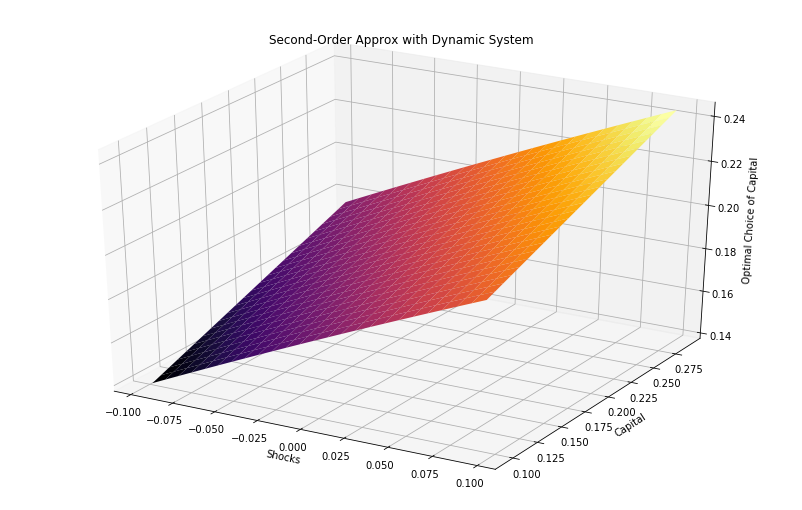

In [68]:
fig = plt.figure(figsize=(14, 9))
Z,K = np.meshgrid(kgrid, zgrid)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K,Z,optK,cmap=cm.inferno)
ax.set_title("Second-Order Approx with Dynamic System")
ax.set_xlabel("Shocks")
ax.set_ylabel("Capital")
ax.set_zlabel("Optimal Choice of Capital")
plt.show()